#### Import libraries & set-up holidays

In [12]:
import pandas as pd
import numpy as np
#import tiingo
import requests
from tqdm import tqdm
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly



## Create holiday calendar
cal = calendar()

holidays = cal.holidays(start='2000-01-01',
                        end='2030-12-30')

holiday_df = pd.DataFrame(data=holidays,
                          columns = ['date']).assign(holiday='USFederalHoliday')

holiday_df.rename(columns={'date':'ds'},inplace=True)
#holiday_df.to_csv('us_holidays_until_2030.csv')

#### Connect to tiingo

In [13]:
# 15min to # 1h 
headers = {
    'Content-Type': 'application/json'
}
requestResponse = requests.get("https://api.tiingo.com/iex/SPY/prices?startDate=2015-01-02&endDate=2022-12-31&resampleFreq=5min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
#print(requestResponse.json())

In [17]:
## The earliest Tiingo 5 min data starts from 2016-12-01 
ticker = 'SPY'
tiingo_time_interval = '5min'
## Tiingo time intervals accepted = 5min, 15min, 30min, 1hour, 4hour


# Generate month_start and month end to use for looping over and getting data month by month
month_start_date  = pd.date_range(start='12/1/2016', end='12/1/2022', freq='MS').strftime('%Y-%m-%d')
month_end_date  = pd.date_range(start='12/1/2016', end='12/31/2022', freq='M').strftime('%Y-%m-%d')
print("the size of the monthly data is " + str(month_end_date.size))


# Below loop gets data for each month on a given interval level for a given ticker

total_df = pd.DataFrame()
for x in tqdm(range(month_start_date.size)):
    month_start = month_start_date[x]
    month_end  = month_end_date[x]
    requestResponse = requests.get("https://api.tiingo.com/iex/"+str(ticker)+"/prices?startDate="+str(month_start)+"&endDate="+str(month_end)+"&resampleFreq="+str(tiingo_time_interval)+"&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
    #print(x) 
    #print("https://api.tiingo.com/iex/SPY/prices?startDate="+str(month_start)+"&endDate="+str(month_end)+"&resampleFreq=5min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b") 
    df_stock = pd.DataFrame(requestResponse.json()) 

    total_df = total_df.append(df_stock)

print('Data download done for the ticker '+str(ticker)+' with a earliest date ' +str(total_df.date.min())+' and latest date '+str(total_df.date.max()))
total_df.to_csv('spy_5_min_all_data.csv')

  0%|          | 0/73 [00:00<?, ?it/s]

the size of the monthly data is 73


100%|██████████| 73/73 [00:55<00:00,  1.32it/s]


Data download done for the ticker SPY with a earliest date 2016-12-12T14:30:00.000Z and latest date 2022-12-05T21:00:00.000Z


In [99]:
df_stock = total_df
df_stock.date = pd.to_datetime(df_stock.date)

## Remove the US public holidays
df_stock = df_stock[~df_stock.date.dt.date.isin(holiday_df.ds)]
df_stock.dtypes

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\algorithms.py:524: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  return f(comps, values)


date      datetime64[ns, UTC]
open                  float64
high                  float64
low                   float64
close                 float64
volume                float64
dtype: object

In [100]:
df_stock.rename(columns={"date": "ds", "close": "y"},inplace=True)
df_stock.ds = df_stock.ds.dt.tz_convert(None)
df_stock.ds.dt.day_name().value_counts()

c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
c:\Users\IvanIvanov\Anaconda3\lib\site-packages\pandas\core\generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Thursday     24646
Tuesday      24569
Wednesday    24568
Friday       24454
Monday       24253
Name: ds, dtype: int64

In [101]:
print(df_stock.shape)
df_stock.ds.dt.hour.value_counts()
mask = np.logical_and(df_stock.ds.dt.hour >= 13,
                      df_stock.ds.dt.hour <= 20)
df_stock = df_stock[mask]
df_stock = df_stock.sort_values('ds',  ascending=True)
df_stock.reset_index(drop=True,inplace=True)
print(df_stock.shape)

(122490, 6)
(121958, 6)


In [102]:
df_stock

,ds,open,high,low,y,volume
0,2016-12-12 14:30:00,226.400,226.535,226.280,226.380,38363.0
1,2016-12-12 14:35:00,226.380,226.575,226.255,226.575,21002.0
2,2016-12-12 14:40:00,226.575,226.580,226.345,226.425,9029.0
3,2016-12-12 14:45:00,226.430,226.645,226.395,226.635,17073.0
4,2016-12-12 14:50:00,226.635,226.770,226.615,226.670,7268.0
...,...,...,...,...,...,...
121953,2022-12-05 20:35:00,399.190,399.660,399.010,399.060,44858.0
121954,2022-12-05 20:40:00,399.055,399.165,398.725,399.115,67785.0
121955,2022-12-05 20:45:00,399.120,399.360,398.800,399.080,18984.0
121956,2022-12-05 20:50:00,399.090,399.545,398.850,399.535,65830.0


#### Prophet

In [103]:
# Python
m = Prophet(holidays=holiday_df, growth = 'linear')
# m = Prophet(holidays=holiday_df, growth = 'linear')
m.fit(df_stock[['ds','y']])

INFO:cmdstanpy:start chain 1


In [ ]:
# Python
future = m.make_future_dataframe(periods=50,freq="5min")
future.tail()

,ds
122535,2022-12-06 00:50:00
122536,2022-12-06 00:55:00
122537,2022-12-06 01:00:00
122538,2022-12-06 01:05:00
122539,2022-12-06 01:10:00


In [87]:
mask = np.logical_and(future.ds.dt.hour >= 13,
                      future.ds.dt.hour <= 20)
future = future[mask]
future = future.sort_values('ds',  ascending=False)
future.reset_index(drop=True,inplace=True)
future.shape

(121958, 1)

#### Prediction results

In [81]:
# Python
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(100)

,ds,yhat,yhat_lower,yhat_upper
100903,2022-12-02 19:45:00,393.663069,382.571493,404.002288
100904,2022-12-02 19:50:00,393.661383,382.333593,405.373085
100905,2022-12-02 19:55:00,393.659318,382.320794,404.853848
100906,2022-12-02 20:00:00,393.656831,382.377854,405.089049
100907,2022-12-02 20:05:00,393.653882,381.831947,405.150365
...,...,...,...,...
100998,2022-12-05 21:35:00,392.867292,382.173802,405.187172
100999,2022-12-05 21:40:00,392.859868,381.684831,404.151233
101000,2022-12-05 21:45:00,392.853391,381.832784,403.957509
101001,2022-12-05 21:50:00,392.848112,381.315957,403.923161


In [82]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(200)

,ds,yhat,yhat_lower,yhat_upper
100803,2022-12-01 17:30:00,393.996179,381.995687,405.734137
100804,2022-12-01 17:35:00,393.994268,382.505487,404.683895
100805,2022-12-01 17:40:00,393.992304,383.298645,405.347948
100806,2022-12-01 17:45:00,393.990303,383.461452,405.463682
100807,2022-12-01 17:50:00,393.988279,382.012151,406.026719
...,...,...,...,...
100998,2022-12-05 21:35:00,392.867292,382.173802,405.187172
100999,2022-12-05 21:40:00,392.859868,381.684831,404.151233
101000,2022-12-05 21:45:00,392.853391,381.832784,403.957509
101001,2022-12-05 21:50:00,392.848112,381.315957,403.923161


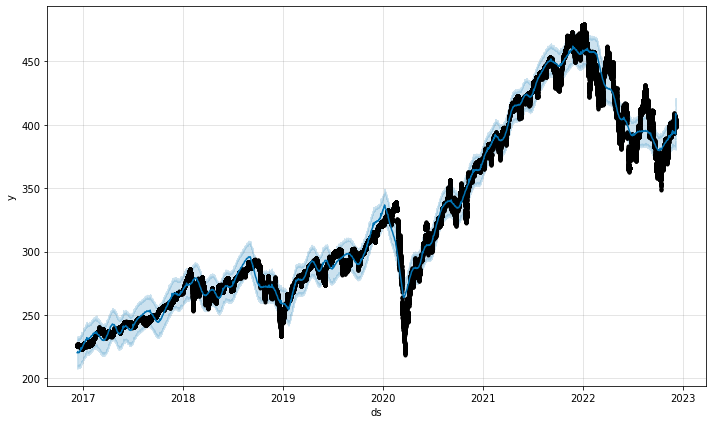

In [29]:
# Python
fig1 = m.plot(forecast)

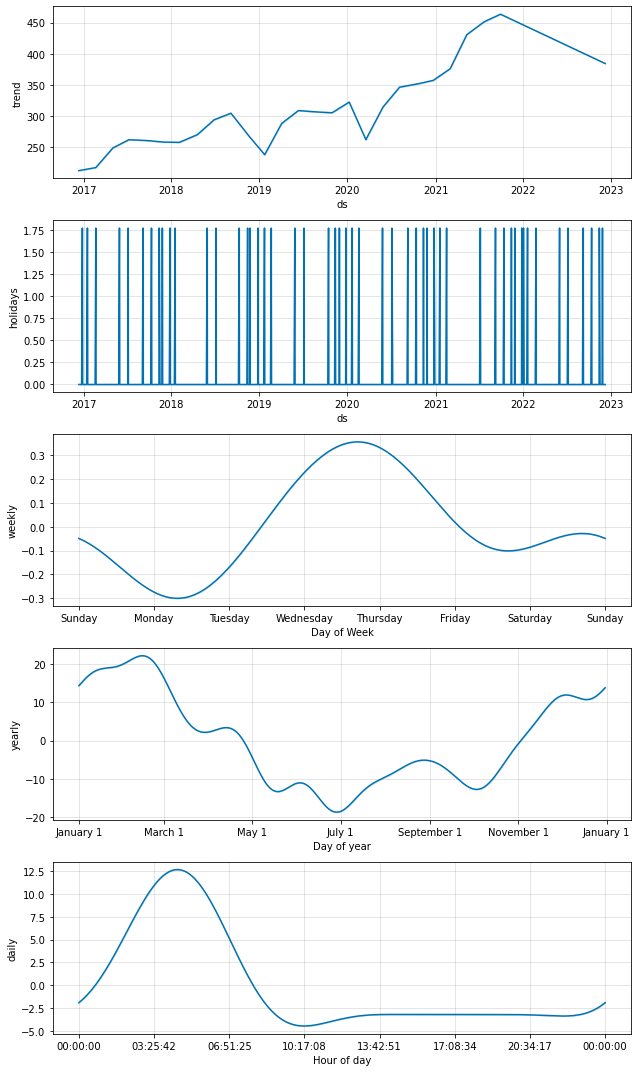

In [30]:
# Python
fig2 = m.plot_components(forecast)

In [ ]:
# Python
plot_plotly(m, forecast)

In [ ]:
# Python
plot_components_plotly(m, forecast)

#### Appendix

In [5]:
#### Test the earleist data available for give ticker

# ticker = 'SPY'

# x = 77


# # Generate month_start and month end to use for looping over and getting data month by month
# month_start_date  = pd.date_range(start='12/1/2010', end='12/1/2022', freq='MS').strftime('%Y-%m-%d')
# month_end_date  = pd.date_range(start='12/1/2010', end='12/31/2022', freq='M').strftime('%Y-%m-%d')
# print("the size of the monthly data is " + str(month_end_date.size))


# month_start = month_start_date[x]
# month_end = month_start_date[x]

# print(month_start_date[x])


# requestResponse = requests.get("https://api.tiingo.com/iex/"+str(ticker)+"/prices?startDate="+str(month_start)+"&endDate="+str(month_end)+"&resampleFreq=15min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b", headers=headers)
# print(x) 
# #print("https://api.tiingo.com/iex/SPY/prices?startDate="+str(month_start)+"&endDate="+str(month_end)+"&resampleFreq=5min&columns=open,high,low,close,volume&token=0ed744c7db5ef348139953912e2f3cee79f4608b") 
# df_stock = pd.DataFrame(requestResponse.json()) 
# df_stock


In [ ]:
# import xgboost as xgb 
# clf_xgb = xgb.XGBRegressor(objective='reg:squarederror', 
#                             tree_method = 'gpu_hist',
#                             gamma = 0.5,
#                            max_depth = 25,
#                             seed=42,
#                             n_estimators=30)

In [ ]:
# clf_xgb.fit(X_train,
#             y_train,
#            verbose=True,
#             early_stopping_rounds=20,
#             eval_metric='rmse',   #aucpr,auc, map
#             eval_set=[(X_test,y_test)])